In [1]:
# Load packages
import numpy as np
import gym
import torch
from torch import nn
import matplotlib.pyplot as plt
from collections import deque
from tqdm import trange
from DQN import DQN

def running_average(x, N):
    ''' Function used to compute the running average
        of the last N elements of a vector x
    '''
    if len(x) >= N:
        y = np.copy(x)
        y[N-1:] = np.convolve(x, np.ones((N, )) / N, mode='valid')
    else:
        y = np.zeros_like(x)
    return y

In [2]:
env = gym.make('LunarLander-v2')
env.reset()

# State/action space description
S = 8
A = 4
E = S + A + 1 + S + 1 # S, A, R, S', done

# Utility parameters
n_ep_running_average = 50                    
n_actions = env.action_space.n               
dim_state = len(env.observation_space.high)  
episode_reward_list = [] 
episode_number_of_steps = [] 

# Hyperparameters
ERB_size = 30000
epsilon0 = 0.99
batch_size = 128
N_episodes = 300
discount_factor = 0.99
learning_rate = 0.0005
hidden_layer_size = 64
C = ERB_size // batch_size

# Experience replay buffer
experience_replay_buffer = deque(maxlen=ERB_size)
def sample_experience_replay_buffer(batch_size):
    indices = np.random.choice(len(experience_replay_buffer), batch_size, replace=False)
    return [ experience_replay_buffer[index] for index in indices ]

# Initialize networks, optimizer and loss function
target = DQN(S, hidden_layer_size, A)
network = DQN(S, hidden_layer_size, A)
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

# Functions used to update the networks
def train_target(network: DQN, target: DQN):
    # simple
    target.load_state_dict(network.state_dict())

def train_network(network: DQN, target: DQN):
    # create torch tensors from experience replay buffer
    states, actions, rewards, next_states, dones = map(lambda x: torch.tensor(x), zip(*sample_experience_replay_buffer(batch_size)))
    states = states.float()
    rewards = rewards.float()
    next_states = next_states.float()
    dones = dones.float()

    # compute loss
    y = rewards + discount_factor * torch.max(target(next_states), dim=1)[0] * (1 - dones)
    q = network(states).gather(1, actions.unsqueeze(1)).squeeze()
    loss = loss_fn(y, q)

    # train
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(network.parameters(), max_norm=1)
    optimizer.step()

Episode:   0%|          | 0/300 [00:00<?, ?it/s]/tmp/ipykernel_182629/956128348.py:45: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  states, actions, rewards, next_states, dones = map(lambda x: torch.tensor(x), zip(*sample_experience_replay_buffer(batch_size)))
Episode 299 - Reward/Steps: 272.1/289 - Avg. Reward/Steps: 212.5/400: 100%|██████████| 300/300 [1:22:13<00:00, 16.45s/it]  


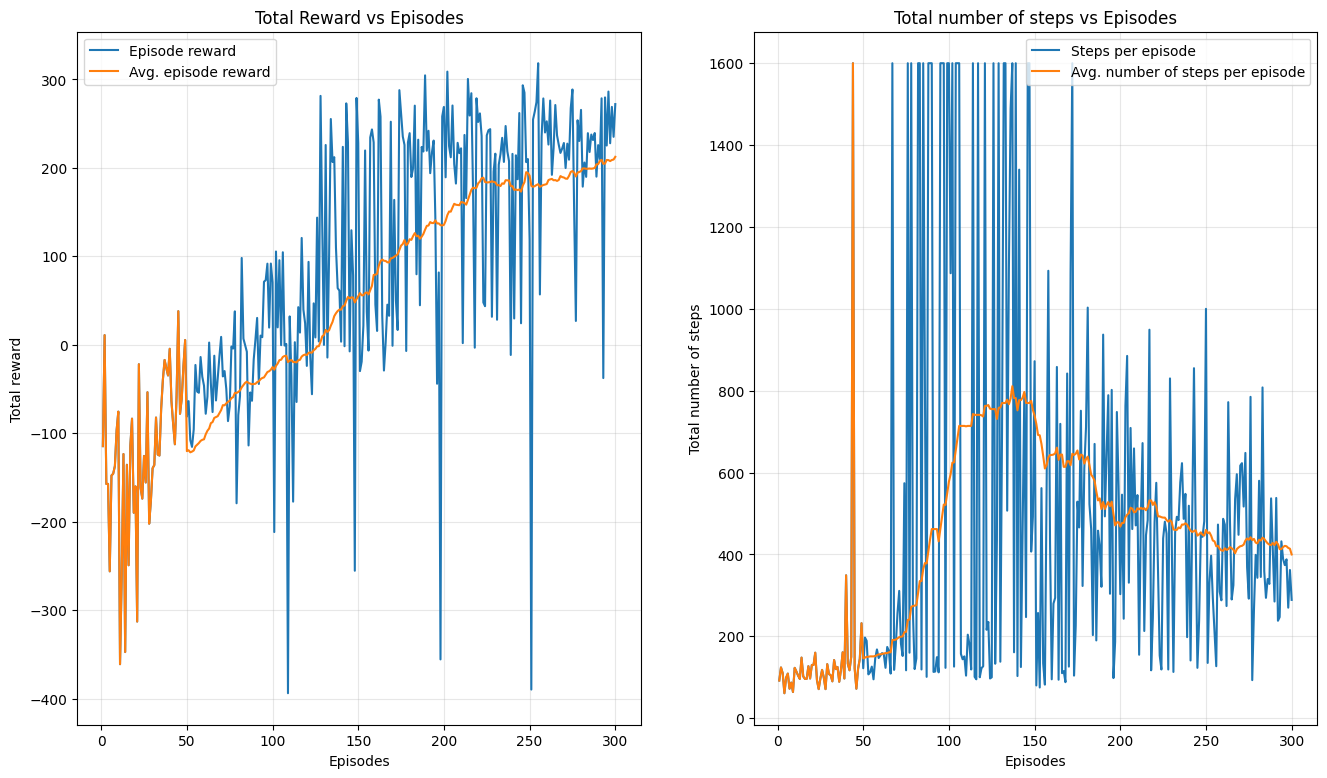

In [3]:
while True:
    done = False
    state, _ = env.reset()
    for _ in range(800):
        if done: break
        action = np.random.randint(0, A)
        next_state, reward, done, _, _ = env.step(action)
        
        experience_replay_buffer.append((state, action, reward, next_state, done))
        
        state = next_state

    if len(experience_replay_buffer) == ERB_size:
        break

c = 0
EPISODES = trange(N_episodes, desc='Episode: ', leave=True)
for i in EPISODES:
    done = False
    state, _ = env.reset()
    total_episode_reward = 0.
    epsilon = epsilon0 * np.exp(- 3 * i / N_episodes)
    t = 0
    for _ in range(1600):
        if done: break
    #while not done:
        # act
        action = network.act(state, epsilon)
        next_state, reward, done, _, _ = env.step(action)
        total_episode_reward += reward

        # train
        train_network(network, target)
        if c % C == 0:
            train_target(network, target)
        
        # update
        experience_replay_buffer.append((state, action, reward, next_state, done))
        state = next_state
        c += 1
        t += 1

    episode_reward_list.append(total_episode_reward)
    episode_number_of_steps.append(t)

    env.close()

    EPISODES.set_description(
        "Episode {} - Reward/Steps: {:.1f}/{} - Avg. Reward/Steps: {:.1f}/{}".format(
        i, total_episode_reward, t,
        running_average(episode_reward_list, n_ep_running_average)[-1],
        running_average(episode_number_of_steps, n_ep_running_average)[-1]))

while len(episode_reward_list) < N_episodes:
    episode_reward_list.append(episode_reward_list[-1])
    episode_number_of_steps.append(episode_number_of_steps[-1])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
ax[0].plot([i for i in range(1, N_episodes+1)], episode_reward_list, label='Episode reward')
ax[0].plot([i for i in range(1, N_episodes+1)], running_average(
    episode_reward_list, n_ep_running_average), label='Avg. episode reward')
ax[0].set_xlabel('Episodes')
ax[0].set_ylabel('Total reward')
ax[0].set_title('Total Reward vs Episodes')
ax[0].legend()
ax[0].grid(alpha=0.3)

ax[1].plot([i for i in range(1, N_episodes+1)], episode_number_of_steps, label='Steps per episode')
ax[1].plot([i for i in range(1, N_episodes+1)], running_average(
    episode_number_of_steps, n_ep_running_average), label='Avg. number of steps per episode')
ax[1].set_xlabel('Episodes')
ax[1].set_ylabel('Total number of steps')
ax[1].set_title('Total number of steps vs Episodes')
ax[1].legend()
ax[1].grid(alpha=0.3)
plt.show()

In [4]:
torch.save(network, 'neural-network-1.pth')